# Deep Learning Model Checkpointing - Keras Implementation
* Notebook by Adam Lang
* Date: 3/4/2024
* We will review and implement `model checkpointing` in this notebook.

# What is Model Checkpointing in Deep Learning?
1. Saves the best model
    * Usually we take the parameters of the model at the very last epoch and use these to make our predictions.
    * Instead, using this technique, we would save the model with the lowest validation loss and use this model.
    * In this example below, we can see the `val_loss` at epoch 50 was 0.6291 whereas the `val_loss` at epoch 45 was actually the best model with a lower `val_loss` of 0.6101, this is the model we want to use.

    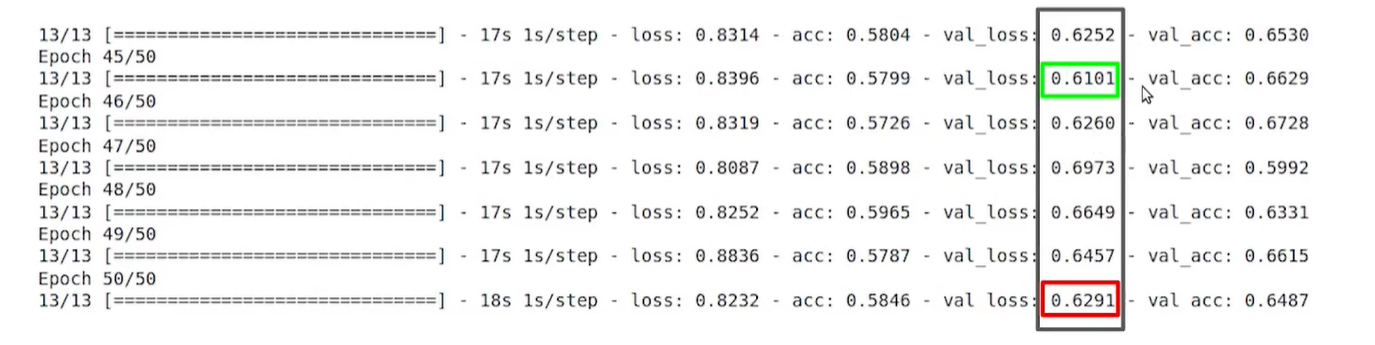

2. In case the system fails or crashes, we don't lose everything!
  * Model is continuously saving checkpoints.

# Model Checkpoints in Keras
* Define 2 parameters
    1. Monitor - quantity to monitor (i.e. validation, accuracy)
    2. Mode - mode of the monitor quantity

Example in Keras:
* Let's say we want to monitor the `val_loss` we would use the `min` as the mode because we want to minimize the `val_loss`.
* Also, for `val_accuracy` we would want the mode set to `max` as we want to maximize the `val_accuracy`.


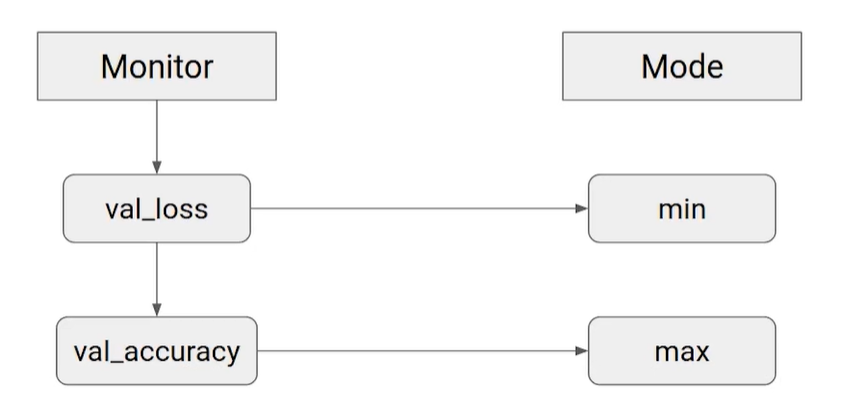


# 1. Importing Libraries and Data preprocessing

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Use git commands to access drive

In [ ]:
ls

drive/  sample_data/


# Steps to solve the Emergency vs. Non-Emergency vehicle binary classification problem
1. Load dataset
2. Pre-process data
3. Create training and validation sets
4. Define model architecture
5. Compile model
6. **Train Model - Set up model checkpointing**
7. Evaluate model performance

# 1. Load dataset and libraries

In [9]:
# import necessary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import layers from keras
from keras.layers import Dense, InputLayer
from keras.models import Sequential
# import adam optimizer form keras optimizer module
from keras.optimizers import Adam

# train_test_split to create training and validation set
from sklearn.model_selection import train_test_split
# accuracy_score to calculate accuracy of predictions
from sklearn.metrics import accuracy_score

In [11]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/0.jpg    
  inflating: Dataset/images/10.jpg   
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1006.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/1009.jpg  
  inflating: Dataset/images/1013.jpg  
  inflating: Dataset/images/1014.jpg  
  inflating: Dataset/images/1016.jpg  
  inflating: Dataset/images/1019.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1020.jpg  
  inflating: Dataset/images/1022.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1026.jpg  
  inflating: Dataset/images/1031.jpg  
  inflating: Dataset/images/1035.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/1037.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images/1040.jpg  
  inflating: Dataset/images/1041.jpg  
  inflating: Dataset/

In [12]:
# read csv file
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/Dataset/emergency_classification.csv')

In [13]:
# define seed value
seed = 42

In [14]:
# view head of data
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [15]:
# load images and store in numpy array

# empty list to store images
X = []
# iterate over each image
for img_name in data.image_names:
  # load image using its name
  img = plt.imread('Dataset/images/' + img_name)
  # saving each image in the list
  X.append(img)

# converting list of images into array
X = np.array(X)

# storing targe variable in separate variable
y = data.emergency_or_not.values

In [16]:
# shape of images
X.shape

(2352, 224, 224, 3)

summary:
* 2,352 input images
* Shape of each image is: 224 x 224 x 3

# 2. Pre-processing the data
* Convert 3 dimensional images into 1 dimension

In [17]:
# converting 3 dimensional image to 1 dimensional image
X = X.reshape(X.shape[0], 224*224*3)
X.shape

(2352, 150528)

In [18]:
# min and max pixel values of images
X.min(), X.max()

(0, 255)

In [19]:
# normalize pixel values
X = X / X.max()

In [20]:
# min and max pixel values of images after normalizing
X.min(), X.max()

(0.0, 1.0)

# 3. Create training and validation sets

In [21]:
# create a training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=seed)

In [22]:
# shape of training and validation sets
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 150528), (1646,)), ((706, 150528), (706,)))

# 4. Define model architecture

In [25]:
# define model architecture
model=Sequential()

model.add(InputLayer(input_shape=(224*224*3,))) #input layer
model.add(Dense(100, activation='sigmoid')) #hidden layer
model.add(Dense(100, activation='sigmoid')) #hidden layer
model.add(Dense(units=1, activation='sigmoid')) # output layer

# 5. Compile model

In [26]:
# define adam optimizer and set learning rate as 10^-5
adam = Adam(learning_rate=1e-5)

In [27]:
# compile model

# define loss as 'binary_crossentropy' as this is a binary classification problem
# define optimizer as Adam
# define metrics as accuracy

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# 6. Training the model - **Set up model checkpointing**
* We will set `mode=max` as we want to maximize the `val_accuracy` which we have set to `monitor`.
* We will set `verbose` to 1 as we want to print a summary after every epoch.
* We will set `save_best_only` to `True` so we can save the best model.

In [28]:
# import model checkpointing from keras callbacks
from keras.callbacks import ModelCheckpoint

In [29]:
# define model checkpointing

# define path to store weights and biases
filepath="best_weights.hdf5"

# define model checkpointing and metric to monitor - validation accuracy after each epoch, verbose will print summary after every epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# define checkpointing variable
callbacks_list = [checkpoint]

In [30]:
# train model for 50 epochs
model_history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid), callbacks=callbacks_list)

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.5905
Epoch 1: val_accuracy improved from -inf to 0.61190, saving model to best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 20s 2s/step - loss: 0.6648 - accuracy: 0.5905 - val_loss: 0.6490 - val_accuracy: 0.6119
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.6306
Epoch 2: val_accuracy improved from 0.61190 to 0.62465, saving model to best_weights.hdf5
13/13 [==============================] - 16s 1s/step - loss: 0.6426 - accuracy: 0.6306 - val_loss: 0.6400 - val_accuracy: 0.6246
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.6652
Epoch 3: val_accuracy improved from 0.62465 to 0.64731, saving model to best_weights.hdf5
13/13 [==============================] - 25s 2s/step - loss: 0.6252 - accuracy: 0.6652 - val_loss: 0.6269 - val_accuracy: 0.6473
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6738
Epoch 4: val_accuracy improved from 0.64731 to 0.66006, saving model to best_weights.hdf5
13/13 [==============================] - 30s 2s/step - loss: 

# 8. Evaluate model performance

In [38]:
# accuracy on validation set
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
print('Accuracy on validation set:', accuracy_score(y_valid, y_pred_classes), '%')

23/23 [==============================] - 1s 56ms/step
Accuracy on validation set: 0.5609065155807366 %


In [39]:
# load best model
model.load_weights("best_weights.hdf5")

In [ ]:
# load best model
model.load_weights("best_weights.hdf5")

# accuracy on validation set
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
print('Accuracy on validation set:', accuracy_score(y_valid, y_pred_classes), '%')